# Backtesting with backtrader library
Notes:  
Timestamp must be in the exact format specified for datafeed   **Timestamp needs to be first column index**  
Params for datafeed need to be specified as tuple of tuples  
Within strategy data is accessed via self.datas[0] for ex: self.datas[0].high_delta[0] would get you the first timeperiod's high_delta  
The current data has already happened and cannot be used to execute an order (ex. you cannot look at the current close price and simultaneously buy the current close, the order will be executed at open instead), orders will be executed on the following day.

In [1]:
import backtrader as bt
import datetime
import pandas as pd

## Define Strategies and Data utils

In [154]:
class BasicStrategy(bt.Strategy):
    def __init__(self):
        # To keep track of pending orders
        self.order = None
        print('***The limit sells for this strategy are valid for 1 day***')
        
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

            # Note: This logic does not properly work
#         elif order.status in [order.Expired]:
#             if order.isbuy():
#                 self.log('BUY ORDER EXPIRED')
#             elif order.issell():
#                 self.log('SELL ORDER EXPIRED')
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None



    def next(self):
        # STRATEGY 
        data = self.datas[0]
        self.log(f'Current Portfolio Value : {self.broker.get_value()}')
        
        # Check if we are in the market
        if not self.position:
            # BUY
            try:
                self.size = int(self.broker.get_cash() / self.datas[0].open[1])
            except:
                print('Size Exception. If at the end of data, ignore.')
            # invest if prediction looks good
            # TODO: Make this a filter in the class constructor
            if (data.prediction[0] >= data.close[0]):
                self.log(f'MARKET BUY CREATE {self.size} shares at next open, current close price: {data.close[0]}')
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=self.size) # market order buys at next open
                
        else:
            # place sell order at predicted high if predicted high is greater than current close price
            if data.prediction[0] > data.close[0]:
                self.log(f'LIMIT SELL CREATE {self.size} shares at {data.prediction[0]}')
                # Keep track of the created order to avoid a 2nd order, order valid for 1 day
                self.order = self.sell(exectype=bt.Order.Limit,
                             price=data.prediction[0],
                             valid=data.datetime.date(0) + datetime.timedelta(days=2),
                             size=self.size)
            # if prediction is less than current value sell at open
            else:
                self.log('MARKET SELL CREATE. PREDICTION < CURRENT CLOSE')
                self.order = self.sell(size=self.size)
        

In [155]:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

      
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.datas[0].open[1])
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print(f'Stop price: {self.datas[0].close[0]}')
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [156]:
def prepare_data(data, fromdate, todate, filepath):
    """Prepare data for backtrader datafeed object
        Returns prepared data filepath and params for the GenericCSVData class, also returns columns used"""
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    # start param setup for backtrader
    start = data['timestamp'].iloc[0]
    end = data['timestamp'].iloc[-1]
    from_to = [(start.year, start.month, start.day), (end.year, end.month, end.day)]
    # Backtrader string format
    data['timestamp'] = data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # backtrader data feed class needs a file path, this could be a temp file that's constantly overwritten
    data.to_csv(filepath)
    
    starting_params = [
    ('fromdate', datetime.datetime(*from_to[0])),
    ('todate', datetime.datetime(*from_to[1])),
    ('nullvalue', 0.0),
    ('dtformat', ('%Y-%m-%d %H:%M:%S')),
    ('tmformat', ('%H:%M:%S')),
    ('datetime', 1)]
    # skip nonfeatures (timestamp)
    cols = data.columns[1:]
    # get column position for each indicator and add to starting params list
    i = 2 # starting index since others are reserved
    for indicator in cols:
        starting_params.append((indicator, i))
        i+=1
    final_params = tuple(starting_params)

    return filepath, final_params, cols 


## Import Data and Run Backtest

In [157]:
import os

In [158]:
def capstone_data_prep(pred_folder_name, pred_col_name, ticker_df_filepath, starting_cash=100000):
    """Main loop, preps data and executes backtrader on all stocks in the prediction folder"""
    ticker_backtesting_dict = {}
    for pred_file in os.listdir(f'../data/ticker_predictions/{pred_folder_name}'):
        ticker_name = pred_file.split('_')[0]
        pred_df = pd.read_csv(f'../data/ticker_predictions/{pred_folder_name}/{pred_file}')
        ticker_df = pd.read_csv(ticker_df_filepath + f'/{ticker_name}_full_data.csv')
        # new prediction column name = "prediction", important because backtester strategy looks for this column name
        ticker_df['prediction'] = pred_df[pred_col_name]
        # remove all non-prediction rows, use "timestamp" as the common datetime name
        ticker_df = ticker_df[ticker_df.prediction > 0]
        ticker_df = ticker_df.rename({'reportperiod':'timestamp'}, axis=1)

        # make timestamp in column position 0 
        ticker_cols = list(ticker_df.columns)
        ticker_cols[5] = 'ts_cpy'
        ticker_cols[0] = 'timestamp'
        ticker_df.columns = ticker_cols
        ticker_df['timestamp'] = ticker_df['ts_cpy']

        # skip nonfeatures, keep timestamp
        nonfeatures = ticker_df.columns[1:7]
        features = [col for col in ticker_df.columns if col not in nonfeatures]
        # get index of start and end dates for trading
        ticker_df = ticker_df[features]
        ticker_df.columns = [c.lower() for c in ticker_df.columns]
        idx1 = ticker_df.prediction[ticker_df.prediction > 0].index[0]
        idx2 = ticker_df.prediction[ticker_df.prediction > 0].index[-1]
        start_date = pred_df.timestamp[idx1]
        end_date  = pred_df.timestamp[idx2]

        # Prepare data for backtrader
        prep_data = prepare_data(ticker_df.copy(), start_date, end_date, 'temp/prep_data.csv')
        class DataFeed(bt.feeds.GenericCSVData):
            lines = tuple(prep_data[2])
            params = prep_data[1]
        
        print(f"--------Ticker Name-------: {ticker_name}")
        ##### BUY AND HOLD #######
        print('BUY AND HOLD')
        # initialize everything and run strategy
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        #cerebro.addsizer(bt.sizers.FixedSize, stake=10)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BuyAndHold)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        buy_hold = cerebro.run()
        buy_hold_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(buy_hold[0].analyzers.sharpe.get_analysis())
        print(buy_hold[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(buy_hold[0].analyzers.returns.get_analysis())

        #### MAIN STRATEGY #####
        cerebro = bt.Cerebro(cheat_on_open=True)
        cerebro.broker.setcash(starting_cash)
        print(f'Starting Portfolio Value: {cerebro.broker.getvalue()}')
        data = DataFeed(dataname=prep_data[0])
        cerebro.adddata(data)
        cerebro.addstrategy(BasicStrategy)
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, _name = 'sharpe')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
        cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
        back = cerebro.run()
        strat_ret = cerebro.broker.getvalue() / starting_cash - 1
        print(f'Final Portfolio Value: {cerebro.broker.getvalue()}\n')
        print('STRATEGY INFO:')
        print(back[0].analyzers.sharpe.get_analysis())
        print(back[0].analyzers.dd.get_analysis())
        # rtot is total log returns over the strategy time period
        print(back[0].analyzers.returns.get_analysis())
        print(f"For {ticker_name}, return was {buy_hold_ret*100}% for buy and hold vs {strat_ret*100}%  for strategy")
        print('\n'*5)

        ticker_backtesting_dict[ticker_name] = cerebro
        
    return ticker_backtesting_dict

In [159]:
cerebro_dict = capstone_data_prep('xgboost_preds', 'holdout_preds', '../data/ticker_data')

--------Ticker Name-------: ADSK
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-18, BUY EXECUTED, 152.13
Stop price: 324.5199890136719
ROI:        113.26%
Final Portfolio Value: 213260.2195739746

STRATEGY INFO:
OrderedDict([('sharperatio', 0.34389316593937563)])
AutoOrderedDict([('len', 51), ('drawdown', 5.184798097797453), ('moneydown', 11661.75), ('max', AutoOrderedDict([('len', 136), ('drawdown', 35.45867074864162), ('moneydown', 49117.31639099124)]))])
OrderedDict([('rtot', 0.7573429222083454), ('ravg', 0.0013998944957640397), ('rnorm', 0.423008671539144), ('rnorm100', 42.3008671539144)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 657 shares at next open, current close price: 153.6699981689453
2019-09-18, BUY EXECUTED, 152.13
2019-09-18, Current Portfolio Value : 99329.85719299316
2019-09-18, LIMIT SELL CREATE 657 shares at 153.13153582674204
2019-0

2020-08-13, BUY EXECUTED, 232.88
2020-08-13, Current Portfolio Value : 159981.92991271365
2020-08-13, LIMIT SELL CREATE 671 shares at 241.35340094351704
2020-08-14, Current Portfolio Value : 157405.292369989
2020-08-14, LIMIT SELL CREATE 671 shares at 237.4624056613429
2020-08-17, Current Portfolio Value : 160525.43827453005
2020-08-17, LIMIT SELL CREATE 671 shares at 242.17415606975555
2020-08-18, SELL EXECUTED, 242.17
2020-08-18, Current Portfolio Value : 162655.29699733603
2020-08-18, MARKET BUY CREATE 665 shares at next open, current close price: 242.69000244140625
2020-08-19, BUY EXECUTED, 244.40
2020-08-19, Current Portfolio Value : 160673.59983852252
2020-08-19, LIMIT SELL CREATE 665 shares at 244.62629420471242
2020-08-20, SELL EXECUTED, 244.63
2020-08-20, Current Portfolio Value : 162805.78670230767
2020-08-20, MARKET BUY CREATE 652 shares at next open, current close price: 249.1499938964844
2020-08-21, BUY EXECUTED, 249.33
2020-08-21, Current Portfolio Value : 162114.66829410

2021-07-07, Current Portfolio Value : 161162.25717280112
2021-07-07, LIMIT SELL CREATE 544 shares at 300.03697058682155
2021-07-08, Current Portfolio Value : 160270.10580561362
2021-07-08, LIMIT SELL CREATE 544 shares at 298.4093928905713
2021-07-09, Current Portfolio Value : 160765.14779780112
2021-07-09, LIMIT SELL CREATE 544 shares at 299.33157049512374
2021-07-12, Current Portfolio Value : 158888.34115717612
2021-07-12, LIMIT SELL CREATE 544 shares at 295.8354043529107
2021-07-13, SELL EXECUTED, 295.84
2021-07-13, Current Portfolio Value : 161012.88510953455
2021-07-13, MARKET BUY CREATE 539 shares at next open, current close price: 296.4200134277344
2021-07-14, BUY EXECUTED, 298.50
2021-07-14, Current Portfolio Value : 160258.28839932947
2021-07-14, LIMIT SELL CREATE 539 shares at 301.01756022872
2021-07-15, Current Portfolio Value : 159013.19971524744
2021-07-15, LIMIT SELL CREATE 539 shares at 298.7336812423382
2021-07-16, Current Portfolio Value : 158226.24787198572
2021-07-16,

--------Ticker Name-------: HD
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-18, BUY EXECUTED, 230.37
Stop price: 368.3999938964844
ROI:        59.91%
Final Portfolio Value: 159905.01947021484

STRATEGY INFO:
OrderedDict([('sharperatio', 0.2678087736341331)])
AutoOrderedDict([('len', 7), ('drawdown', 1.0527348079031698), ('moneydown', 1701.2858276367479), ('max', AutoOrderedDict([('len', 143), ('drawdown', 38.398844103663656), ('moneydown', 41173.58450317381)]))])
OrderedDict([('rtot', 0.46940982466753095), ('ravg', 0.0008676706555776913), ('rnorm', 0.24439940164811577), ('rnorm100', 24.439940164811578)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 434 shares at next open, current close price: 230.2100067138672
2019-09-18, BUY EXECUTED, 230.37
2019-09-18, Current Portfolio Value : 100199.64291381836
2019-09-18, LIMIT SELL CREATE 434 shares at 232.7330831

2020-08-13, Current Portfolio Value : 132608.41072960504
2020-08-13, LIMIT SELL CREATE 470 shares at 283.9821536366071
2020-08-14, Current Portfolio Value : 132086.70327110894
2020-08-14, LIMIT SELL CREATE 470 shares at 282.8629862255766
2020-08-17, Current Portfolio Value : 135701.00441856988
2020-08-17, LIMIT SELL CREATE 470 shares at 290.61638900334947
2020-08-18, Current Portfolio Value : 134178.20900841363
2020-08-18, LIMIT SELL CREATE 470 shares at 287.34968662261963
2020-08-19, SELL EXECUTED, 287.46
2020-08-19, Current Portfolio Value : 135334.40499230035
2020-08-19, MARKET BUY CREATE 482 shares at next open, current close price: 282.8599853515625
2020-08-20, BUY EXECUTED, 280.54
2020-08-20, Current Portfolio Value : 135401.87734337454
2020-08-20, LIMIT SELL CREATE 482 shares at 282.994062935526
2020-08-21, SELL EXECUTED, 282.99
2020-08-21, Current Portfolio Value : 136517.25920857152
2020-08-21, MARKET BUY CREATE 479 shares at next open, current close price: 283.2300109863281
2

2021-06-14, LIMIT SELL CREATE 434 shares at 311.8702005990199
2021-06-15, Current Portfolio Value : 133121.8597811175
2021-06-15, LIMIT SELL CREATE 434 shares at 308.9765437655733
2021-06-16, Current Portfolio Value : 131529.07395348078
2021-06-16, LIMIT SELL CREATE 434 shares at 305.276272859046
2021-06-17, Current Portfolio Value : 131676.6323641253
2021-06-17, LIMIT SELL CREATE 434 shares at 305.85141854654654
2021-06-18, Current Portfolio Value : 131455.28812584406
2021-06-18, LIMIT SELL CREATE 434 shares at 305.3368130675226
2021-06-21, Current Portfolio Value : 133620.95713219172
2021-06-21, LIMIT SELL CREATE 434 shares at 310.1360188033723
2021-06-22, SELL EXECUTED, 310.14
2021-06-22, Current Portfolio Value : 134721.5866439295
2021-06-22, MARKET BUY CREATE 431 shares at next open, current close price: 312.7099914550781
2021-06-23, BUY EXECUTED, 312.02
2021-06-23, Current Portfolio Value : 134570.74716639044
2021-06-23, LIMIT SELL CREATE 431 shares at 314.2395813618496
2021-06-2

--------Ticker Name-------: MSFT
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 135.83
Stop price: 336.05999755859375
ROI:        147.37%
Final Portfolio Value: 247369.27685546875

STRATEGY INFO:
OrderedDict([('sharperatio', 0.6058303182921891)])
AutoOrderedDict([('len', 1), ('drawdown', 0.11293550081642684), ('moneydown', 279.68359375), ('max', AutoOrderedDict([('len', 98), ('drawdown', 28.229375275033707), ('moneydown', 39214.07910156253)]))])
OrderedDict([('rtot', 0.9057120821661244), ('ravg', 0.0016679780518713157), ('rnorm', 0.5224645999566062), ('rnorm100', 52.24645999566062)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, MARKET BUY CREATE 736 shares at next open, current close price: 137.32000732421878
2019-09-16, BUY EXECUTED, 135.83
2019-09-16, Current Portfolio Value : 100368.0
2019-09-16, LIMIT SELL CREATE 736 shares at 137.58915899775823
2019-0

2020-08-14, Current Portfolio Value : 166692.83276447782
2020-08-14, LIMIT SELL CREATE 797 shares at 211.43806439375115
2020-08-17, Current Portfolio Value : 167792.69665607935
2020-08-17, LIMIT SELL CREATE 797 shares at 212.8013459583781
2020-08-18, Current Portfolio Value : 168757.07200703153
2020-08-18, LIMIT SELL CREATE 797 shares at 213.9561511704124
2020-08-19, Current Portfolio Value : 167330.43519672877
2020-08-19, LIMIT SELL CREATE 797 shares at 212.17449254964774
2020-08-20, SELL EXECUTED, 212.17
2020-08-20, Current Portfolio Value : 169302.608191049
2020-08-20, MARKET BUY CREATE 791 shares at next open, current close price: 214.5800018310547
2020-08-21, BUY EXECUTED, 213.86
2020-08-21, Current Portfolio Value : 168638.17108777745
2020-08-21, LIMIT SELL CREATE 791 shares at 214.75712912467316
2020-08-24, Current Portfolio Value : 169168.13963941322
2020-08-24, LIMIT SELL CREATE 791 shares at 215.48101671834598
2020-08-25, SELL EXECUTED, 215.48
2020-08-25, Current Portfolio Va

2021-06-28, Current Portfolio Value : 157248.20767107452
2021-06-28, LIMIT SELL CREATE 585 shares at 270.79137858378084
2021-06-29, SELL EXECUTED, 270.79
2021-06-29, Current Portfolio Value : 158459.96342847502
2021-06-29, MARKET BUY CREATE 585 shares at next open, current close price: 271.39999389648443
2021-06-30, BUY EXECUTED, 270.69
2021-06-30, Current Portfolio Value : 158582.80842969575
2021-06-30, LIMIT SELL CREATE 585 shares at 272.9804893978581
2021-07-01, Current Portfolio Value : 158992.31557080898
2021-07-01, LIMIT SELL CREATE 585 shares at 273.6858776561275
2021-07-02, SELL EXECUTED, 273.69
2021-07-02, Current Portfolio Value : 160212.55042908696
2021-07-02, MARKET BUY CREATE 576 shares at next open, current close price: 277.64999389648443
2021-07-06, BUY EXECUTED, 278.03
2021-07-06, Current Portfolio Value : 159999.43324158696
2021-07-06, LIMIT SELL CREATE 576 shares at 279.6144057007114
2021-07-07, SELL EXECUTED, 279.61
2021-07-07, Current Portfolio Value : 161125.168815

--------Ticker Name-------: UNH
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 232.82
Stop price: 455.80999755859375
ROI:        95.66%
Final Portfolio Value: 195662.70581054688

STRATEGY INFO:
OrderedDict([('sharperatio', 0.37044525067164297)])
AutoOrderedDict([('len', 5), ('drawdown', 1.0113947620784514), ('moneydown', 1999.1415710449219), ('max', AutoOrderedDict([('len', 70), ('drawdown', 36.14317098989917), ('moneydown', 47383.048690795884)]))])
OrderedDict([('rtot', 0.6712221020907545), ('ravg', 0.0012361364679387744), ('rnorm', 0.3654805117079781), ('rnorm100', 36.548051170797805)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, MARKET BUY CREATE 429 shares at next open, current close price: 233.6100006103516
2019-09-16, BUY EXECUTED, 232.82
2019-09-16, Current Portfolio Value : 100690.68371582031
2019-09-16, LIMIT SELL CREATE 429 shares at 237.0148515

2020-07-29, Current Portfolio Value : 157362.61325760017
2020-07-29, MARKET BUY CREATE 521 shares at next open, current close price: 306.67999267578125
2020-07-30, BUY EXECUTED, 301.68
2020-07-30, Current Portfolio Value : 159212.1727973951
2020-07-30, LIMIT SELL CREATE 521 shares at 308.2990094753077
2020-07-31, Current Portfolio Value : 157935.7164375318
2020-07-31, LIMIT SELL CREATE 521 shares at 305.8202483746027
2020-08-03, Current Portfolio Value : 158368.1394416822
2020-08-03, LIMIT SELL CREATE 521 shares at 306.61745354328013
2020-08-04, SELL EXECUTED, 306.62
2020-08-04, Current Portfolio Value : 159935.0303695671
2020-08-04, MARKET BUY CREATE 521 shares at next open, current close price: 304.5
2020-08-05, BUY EXECUTED, 306.83
2020-08-05, Current Portfolio Value : 162873.47800140304
2020-08-05, LIMIT SELL CREATE 521 shares at 315.39023669787633
2020-08-06, SELL EXECUTED, 315.39
2020-08-06, Current Portfolio Value : 164394.9206850103
2020-08-06, MARKET BUY CREATE 524 shares at n

2021-06-02, LIMIT SELL CREATE 500 shares at 410.27426334120537
2021-06-03, Current Portfolio Value : 204098.96173963495
2021-06-03, LIMIT SELL CREATE 500 shares at 412.3575475534599
2021-06-04, Current Portfolio Value : 202938.97333631464
2021-06-04, LIMIT SELL CREATE 500 shares at 410.0619827246119
2021-06-07, Current Portfolio Value : 200243.9660120959
2021-06-07, LIMIT SELL CREATE 500 shares at 404.68897944688797
2021-06-08, Current Portfolio Value : 200988.9611292834
2021-06-08, LIMIT SELL CREATE 500 shares at 406.2427151062293
2021-06-09, Current Portfolio Value : 200668.9690638537
2021-06-09, LIMIT SELL CREATE 500 shares at 405.59555799649394
2021-06-10, Current Portfolio Value : 200863.9611292834
2021-06-10, LIMIT SELL CREATE 500 shares at 405.91079830264783
2021-06-11, Current Portfolio Value : 199063.97333631464
2021-06-11, LIMIT SELL CREATE 500 shares at 402.2634044910228
2021-06-14, Current Portfolio Value : 199698.96784315057
2021-06-14, LIMIT SELL CREATE 500 shares at 403.

--------Ticker Name-------: WAT
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 230.14
Stop price: 343.05999755859375
ROI:        49.01%
Final Portfolio Value: 149007.27920532227

STRATEGY INFO:
OrderedDict([('sharperatio', 0.21660704735019595)])
AutoOrderedDict([('len', 42), ('drawdown', 19.210556121300453), ('moneydown', 35431.766357421875), ('max', AutoOrderedDict([('len', 227), ('drawdown', 33.445903267223045), ('moneydown', 37310.980529785156)]))])
OrderedDict([('rtot', 0.39882497249105836), ('ravg', 0.0007344842955636434), ('rnorm', 0.20332678578026106), ('rnorm100', 20.332678578026105)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, MARKET BUY CREATE 434 shares at next open, current close price: 232.1300048828125
2019-09-16, BUY EXECUTED, 230.14
2019-09-16, Current Portfolio Value : 100598.92211914061
2019-09-16, LIMIT SELL CREATE 434 shares at 233.74

2020-08-12, BUY EXECUTED, 215.73
2020-08-12, Current Portfolio Value : 89280.28077459912
2020-08-12, LIMIT SELL CREATE 414 shares at 217.27890545981242
2020-08-13, SELL EXECUTED, 217.28
2020-08-13, Current Portfolio Value : 90136.80485542044
2020-08-13, MARKET BUY CREATE 416 shares at next open, current close price: 217.0
2020-08-14, BUY EXECUTED, 216.35
2020-08-14, Current Portfolio Value : 89741.59977729547
2020-08-14, LIMIT SELL CREATE 416 shares at 217.4707190642112
2020-08-17, Current Portfolio Value : 89858.07926948296
2020-08-17, LIMIT SELL CREATE 416 shares at 217.7534095822993
2020-08-18, Current Portfolio Value : 89600.16130073294
2020-08-18, LIMIT SELL CREATE 416 shares at 217.12745420731514
2020-08-19, SELL EXECUTED, 217.13
2020-08-19, Current Portfolio Value : 90460.22326660105
2020-08-19, MARKET BUY CREATE 420 shares at next open, current close price: 216.9499969482422
2020-08-20, BUY EXECUTED, 215.29
2020-08-20, Current Portfolio Value : 90225.02429199166
2020-08-20, LIM

2021-06-29, Current Portfolio Value : 113073.61149926561
2021-06-29, LIMIT SELL CREATE 327 shares at 348.46805703136846
2021-06-30, Current Portfolio Value : 113224.02870507615
2021-06-30, LIMIT SELL CREATE 327 shares at 348.93247056588007
2021-07-01, SELL EXECUTED, 348.93
2021-07-01, Current Portfolio Value : 114310.481370158
2021-07-01, MARKET BUY CREATE 325 shares at next open, current close price: 351.17999267578125
2021-07-02, BUY EXECUTED, 351.36
2021-07-02, Current Portfolio Value : 115652.73295707206
2021-07-02, LIMIT SELL CREATE 325 shares at 358.9074558356369
2021-07-06, Current Portfolio Value : 116816.23851127128
2021-07-06, LIMIT SELL CREATE 325 shares at 362.5218890429314
2021-07-07, SELL EXECUTED, 362.52
2021-07-07, Current Portfolio Value : 117938.10006985288
2021-07-07, MARKET BUY CREATE 327 shares at next open, current close price: 365.3999938964844
2021-07-08, BUY EXECUTED, 360.50
2021-07-08, Current Portfolio Value : 119631.95767483335
2021-07-08, LIMIT SELL CREATE 

--------Ticker Name-------: XOM
BUY AND HOLD
Starting Portfolio Value: 100000
2019-09-16, BUY EXECUTED, 75.04
Stop price: 65.01999664306639
ROI:        -13.35%
Final Portfolio Value: 86653.35430908202

STRATEGY INFO:
OrderedDict([('sharperatio', -0.0013831845085095012)])
AutoOrderedDict([('len', 542), ('drawdown', 13.346645690917983), ('moneydown', 13346.645690917983), ('max', AutoOrderedDict([('len', 542), ('drawdown', 58.06188020324707), ('moneydown', 58061.88020324707)]))])
OrderedDict([('rtot', -0.143254459564972), ('ravg', -0.00026382036752296866), ('rnorm', -0.06432092755311768), ('rnorm100', -6.432092755311768)])
Starting Portfolio Value: 100000
***The limit sells for this strategy are valid for 1 day***
2019-09-13, Current Portfolio Value : 100000.0
2019-09-13, MARKET BUY CREATE 1332 shares at next open, current close price: 72.63999938964844
2019-09-16, BUY EXECUTED, 75.04
2019-09-16, Current Portfolio Value : 98255.08325195312
2019-09-16, LIMIT SELL CREATE 1332 shares at 74.2

2020-08-19, BUY EXECUTED, 42.35
2020-08-19, Current Portfolio Value : 84818.7752098388
2020-08-19, LIMIT SELL CREATE 2021 shares at 42.350111757349616
2020-08-20, Current Portfolio Value : 83525.33644335931
2020-08-20, LIMIT SELL CREATE 2021 shares at 41.721431733981255
2020-08-21, Current Portfolio Value : 82898.82366793817
2020-08-21, LIMIT SELL CREATE 2021 shares at 41.4084186355126
2020-08-24, Current Portfolio Value : 85344.2395271606
2020-08-24, LIMIT SELL CREATE 2021 shares at 42.61103639302747
2020-08-25, Current Portfolio Value : 82636.09921878044
2020-08-25, LIMIT SELL CREATE 2021 shares at 41.27715843284704
2020-08-26, Current Portfolio Value : 80877.82366793817
2020-08-26, LIMIT SELL CREATE 2021 shares at 40.715044733510695
2020-08-27, Current Portfolio Value : 80332.16045230096
2020-08-27, LIMIT SELL CREATE 2021 shares at 40.178081175710304
2020-08-28, SELL EXECUTED, 40.18
2020-08-28, Current Portfolio Value : 81217.51911623009
2020-08-28, MARKET BUY CREATE 1998 shares at 

2021-06-23, LIMIT SELL CREATE 1901 shares at 64.90327565901134
2021-06-24, Current Portfolio Value : 122652.70662830236
2021-06-24, LIMIT SELL CREATE 1901 shares at 65.11845545992854
2021-06-25, Current Portfolio Value : 122918.8599715031
2021-06-25, LIMIT SELL CREATE 1901 shares at 65.10186895250446
2021-06-28, Current Portfolio Value : 119782.19981906777
2021-06-28, LIMIT SELL CREATE 1901 shares at 63.64833017317778
2021-06-29, SELL EXECUTED, 63.65
2021-06-29, Current Portfolio Value : 120995.66866904411
2021-06-29, MARKET BUY CREATE 1929 shares at next open, current close price: 62.61999893188477
2021-06-30, BUY EXECUTED, 62.70
2021-06-30, Current Portfolio Value : 121728.6907294384
2021-06-30, LIMIT SELL CREATE 1929 shares at 63.6982132328194
2021-07-01, SELL EXECUTED, 64.33
2021-07-01, Current Portfolio Value : 124139.9407294384
2021-07-01, MARKET BUY CREATE 1970 shares at next open, current close price: 63.2599983215332
2021-07-02, BUY EXECUTED, 63.01
2021-07-02, Current Portfoli

### Library additionally has plotting
Not sure how to reformat this, it's pretty ugly

<IPython.core.display.Javascript object>


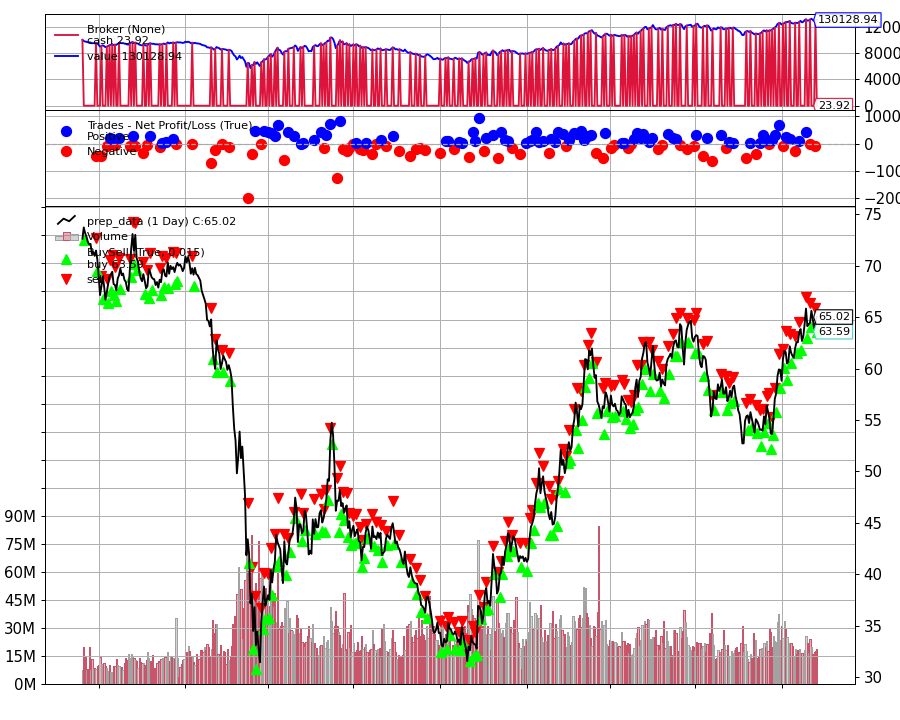

[[<Figure size 720x576 with 4 Axes>]]

In [164]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 12}) 
cerebro_dict['XOM'].plot()

### Ways to Improve:

Increase strategy trading volume. There are certain periods where sell orders are not going through for multiple days in a row, meaning that the price is lower than anticipated by model for that period. For example, if the last sell order didn't go through, we can find a way to use that information to inform our next sell order and make the prediction lower or try a market sell. Maybe train a "bear" model, one that only knows pain and suffering of bear markets, and only produces pessimistic high price predictions.   

Smarter entry points. Currently, buy orders are being executed at market price at the open. Returns may increase if entry constraints are increased.